<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/nn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [531]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

file_path = "drive/MyDrive/Code/rawData/data_small.txt"
dataset = read_dataset(file_path)[1:]
print(dataset[:10])

[('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there'), ('Greet', 'Hi how can I help you?')]


In [532]:
intent_counts = {}
for intent, _ in dataset:
    if intent not in intent_counts:
        intent_counts[intent] = 0
    intent_counts[intent] += 1
print(intent_counts)
print(f"Number of examples in dataset: {len(dataset)}")
print(f"Number of examples in training dataset: {len(training_data)}")
print(f"Number of examples in cv dataset: {len(test_data)}")

{'Greet': 53, 'Farewell': 66, 'Inquiry': 50, 'Feedback': 50, 'Complaint': 38, 'Request': 50, 'Navigation': 58}
Number of examples in dataset: 365
Number of examples in training dataset: 219
Number of examples in cv dataset: 146


In [533]:
all_sentences = set(sentence for intent, sentence in dataset)
print(f"All unique sentences count: {len(all_sentences)}")

All unique sentences count: 355


In [534]:
# Check for duplicates
# from collections import Counter
# word_counts = Counter(sentence for intent, sentence in dataset)
# word_counts

In [535]:
from itertools import chain

all_words = set(chain(*[sentence.lower().split(" ") for intent, sentence in dataset]))
print(f"All unique sentences count: {len(all_words)}")

All unique sentences count: 723


In [536]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [537]:
word_to_index = {char: i for i, char in enumerate(all_words)}
print(f"No of words: {len(all_words)}")
print(word_to_index.items())

No of words: 723
dict_items([('way', 0), ('share', 1), ('until', 2), ('color?', 3), ('doing', 4), ('assist', 5), ('solution', 6), ('excellent', 7), ('pm.', 8), ('by', 9), ('lot', 10), ('reliable', 11), ('seamless', 12), ('soon!', 13), ('change', 14), ('navigate', 15), ('and', 16), ('many', 17), ('explanations.', 18), ('advanced', 19), ('easy!', 20), ('incorrect.', 21), ('understand', 22), ("mornin'", 23), ('bookmark', 24), ('one', 25), ('leaky', 26), ('up?', 27), ('make', 28), ('effort', 29), ('impairments.', 30), ('year?', 31), ('hiking', 32), ('hotel', 33), ('works?', 34), ('pricing', 35), ('fit', 36), ('goodbye', 37), ('glad', 38), ('issue?', 39), ('items', 40), ('help', 41), ('message', 42), ('easy', 43), ('tutorial', 44), ('tight!', 45), ('here', 46), ("there's", 47), ('shall', 48), ('next', 49), ('awesome', 50), ('explain', 51), ('mailing', 52), ('certain', 53), ("farmers'", 54), ('summarize', 55), ('responsive', 56), ('new?', 57), ('query?', 58), ('all!', 59), ('upload', 60), ('

In [538]:
all_intents = set(intent for intent, _ in dataset[1:])
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {intent: i for i, intent in intent_to_index.items()}

print(f"No of intents {len(all_intents)}")
print(intent_to_index.items())
print(index_to_intent.items())

No of intents 7
dict_items([('Feedback', 0), ('Greet', 1), ('Complaint', 2), ('Inquiry', 3), ('Navigation', 4), ('Request', 5), ('Farewell', 6)])
dict_items([(0, 'Feedback'), (1, 'Greet'), (2, 'Complaint'), (3, 'Inquiry'), (4, 'Navigation'), (5, 'Request'), (6, 'Farewell')])


In [539]:
def sentence_to_tensor(sentence):
    # print(sentence)
    tensor = torch.zeros(len(all_words)).to(device)
    for i, word in enumerate(sentence.lower().split(" ")):
        tensor[word_to_index[word]] = 1

    return tensor

In [540]:
# def tensor_to_sentence(tensor, all_words, word_to_index):
#     sentence = []
#     for i in range(len(tensor)):
#         if tensor[i] == 1:
#             word = list(word_to_index.keys())[list(word_to_index.values()).index(i)]
#             sentence.append(word)
#     return " ".join(sentence)


In [541]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, feature_transform=None, label_transform=None):
        self.data = dataset
        self.feature_transform = feature_transform
        self.label_transform = label_transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return label_transform[sample[0]], feature_transform(sample[1])
            # sample[1] = self.transform(sample[1])


In [542]:
feature_transform = transforms.Compose([
    sentence_to_tensor,
])
label_transform = intent_to_index

In [543]:
from sklearn.model_selection import train_test_split

training_data, test_data = train_test_split(dataset, test_size=0.4, random_state=42)

In [544]:
BATCH_SIZE = 32

train_dataset = CustomDataset(training_data, feature_transform=feature_transform, label_transform=label_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = CustomDataset(test_data, feature_transform=feature_transform, label_transform=label_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [545]:
# Access individual samples from the dataset
# for i in range(len(train_dataset[5:10])):
#     sample = train_dataset[i]
    # print(sample)

In [546]:
for batch, (intent, sentence) in enumerate(train_loader):
    if batch == 15:
      break
    print(sentence.shape)
    print(intent.shape)
    print(intent)

    # print(sentence)
    # print(len(sentence))
    print("-----------")

torch.Size([32, 723])
torch.Size([32])
tensor([3, 0, 5, 1, 6, 6, 5, 0, 4, 6, 4, 1, 5, 2, 0, 1, 5, 2, 6, 6, 3, 6, 3, 5,
        0, 1, 4, 1, 4, 4, 5, 6])
-----------
torch.Size([32, 723])
torch.Size([32])
tensor([5, 2, 6, 3, 6, 0, 1, 4, 0, 5, 3, 0, 5, 3, 3, 5, 6, 4, 0, 6, 0, 3, 1, 6,
        0, 1, 2, 6, 1, 0, 2, 0])
-----------
torch.Size([32, 723])
torch.Size([32])
tensor([4, 0, 3, 1, 6, 0, 4, 2, 2, 6, 5, 4, 0, 0, 5, 0, 0, 5, 4, 3, 1, 1, 4, 4,
        3, 6, 4, 1, 0, 5, 6, 3])
-----------
torch.Size([32, 723])
torch.Size([32])
tensor([0, 4, 6, 5, 3, 3, 0, 4, 2, 1, 0, 3, 6, 5, 1, 6, 3, 0, 6, 3, 1, 2, 2, 4,
        3, 5, 4, 5, 4, 0, 3, 1])
-----------
torch.Size([32, 723])
torch.Size([32])
tensor([1, 0, 2, 4, 4, 1, 5, 3, 5, 5, 5, 6, 3, 0, 6, 4, 0, 5, 1, 1, 2, 4, 4, 5,
        1, 2, 1, 3, 0, 6, 5, 3])
-----------
torch.Size([32, 723])
torch.Size([32])
tensor([6, 3, 1, 5, 1, 6, 4, 5, 1, 3, 0, 2, 2, 2, 2, 6, 2, 6, 4, 5, 4, 3, 5, 1,
        3, 0, 6, 2, 6, 2, 3, 1])
-----------


In [547]:
class MyModel(nn.Module):
    def __init__(self, word_count, intent_class_count, hidden_units):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(word_count, hidden_units)
        self.fc2 = nn.Linear(hidden_units, intent_class_count)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [548]:
def train_step(model, dataloader, optimizer, loss_fn):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (intent, sentence) in enumerate(dataloader):

        # intent_tensor = intent_to_tensor(intent)
        train_pred_logits = model(sentence)
        loss = loss_fn(train_pred_logits, intent)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss = loss_fn(train_pred_logits, intent)

        train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
        train_acc += (train_pred_class == intent).sum().item() / len(train_pred_class)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [549]:
def test_step(model, dataloader, loss_fn):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (intent, sentence) in enumerate(dataloader):

        # intent_tensor = intent_to_tensor(intent)
        train_pred_logits = model(sentence)
        loss = loss_fn(train_pred_logits, intent)

        train_loss += loss.item()
        loss = loss_fn(train_pred_logits, intent)

        train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
        train_acc += (train_pred_class == intent).sum().item() / len(train_pred_class)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [550]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, epochs, optimizer, loss_fn):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
          train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)

          test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn)

          # 4. Print out what's happening
          print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )

          # 5. Update results dictionary
          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(test_loss)
          results["test_acc"].append(test_acc)

      # 6. Return the filled results at the end of the epochs
    return results

In [551]:
model = MyModel(len(all_words), len(all_intents), 128)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [552]:
model_0_results = train(model, train_dataloader, test_dataloader, 100, optimizer, loss_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9382 | train_acc: 0.2351 | test_loss: 1.9320 | test_acc: 0.2931
Epoch: 2 | train_loss: 1.8933 | train_acc: 0.4921 | test_loss: 1.9079 | test_acc: 0.3653
Epoch: 3 | train_loss: 1.8428 | train_acc: 0.6147 | test_loss: 1.8777 | test_acc: 0.4674
Epoch: 4 | train_loss: 1.7817 | train_acc: 0.7288 | test_loss: 1.8367 | test_acc: 0.5208
Epoch: 5 | train_loss: 1.6989 | train_acc: 0.7994 | test_loss: 1.7834 | test_acc: 0.6146
Epoch: 6 | train_loss: 1.6003 | train_acc: 0.8555 | test_loss: 1.7188 | test_acc: 0.6382
Epoch: 7 | train_loss: 1.4753 | train_acc: 0.8867 | test_loss: 1.6395 | test_acc: 0.6632
Epoch: 8 | train_loss: 1.3406 | train_acc: 0.8948 | test_loss: 1.5515 | test_acc: 0.6757
Epoch: 9 | train_loss: 1.1917 | train_acc: 0.9233 | test_loss: 1.4546 | test_acc: 0.6944
Epoch: 10 | train_loss: 1.0376 | train_acc: 0.9509 | test_loss: 1.3496 | test_acc: 0.7257
Epoch: 11 | train_loss: 0.8876 | train_acc: 0.9777 | test_loss: 1.2470 | test_acc: 0.7382
Epoch: 12 | train_l

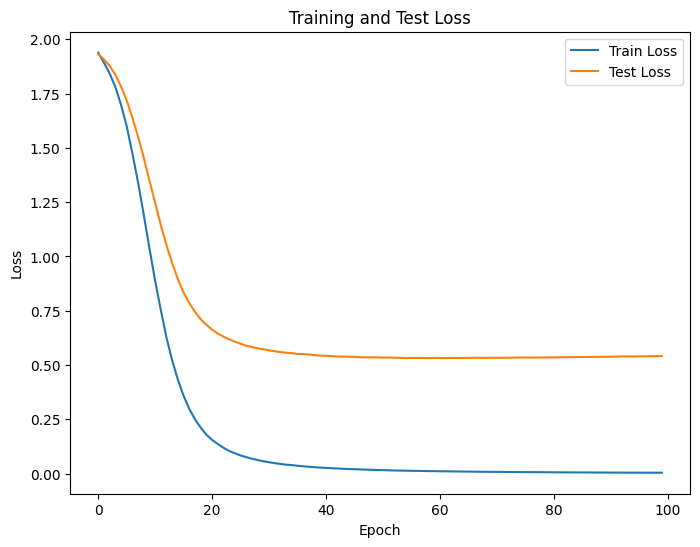

In [553]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(model_0_results["train_loss"], label="Train Loss")
ax.plot(model_0_results["test_loss"], label="Test Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and Test Loss")
ax.legend()
plt.show()

In [556]:
def predict(model, input_data):
    with torch.no_grad():
        pred_logits = model(input_data)
        pred_class = torch.argmax(torch.softmax(pred_logits, dim=0), dim=0)

        return index_to_intent[pred_class.item()]

In [563]:
print(predict(model,  sentence_to_tensor("hI frIend bye see ya")))

Farewell
